# Modelowanie ARMA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [2]:
def check_time_series_stationary(y, rolling_len=12):
    
    y = pd.Series(y)
    df_test = adfuller(y)
    
    if df_test[1] < 0.05:
        print('Szereg jest stacjonarny')
    
    else:
        print('Szereg jest niestacjonarny')
    
    print("{0:^32s}".format("Dickey-Fuller Test"))
    print("-"*32+"\n")
    
    print("{0:<20s}: {1:>10.4f}".format('Test Statistic', df_test[0]))
    print("{0:<20s}: {1:>10.4f}".format('p-value', df_test[1]))
    print("-"*32+"\n")
    
    rolling_mean = y.rolling(rolling_len).mean()
    rolling_var = y.rolling(rolling_len).var()

    plt.plot(y)
    plt.plot(rolling_mean, label="Rolling mean")
    plt.plot(rolling_var, label="Rolling var")
    plt.legend()
    plt.show()
    
    print("{0:^32s}".format("Autocorrelation plot"))
    print("-"*32+"\n")
    
    pd.plotting.autocorrelation_plot(y)
    plt.show()

## Zadanie 1

Dokonaj analizy szeregu czasowego `USGDP`. Dopasuj odpowiedni model i dokonaj predykcji.

In [3]:
usgdp = pd.read_csv('../data/USGDP.csv', parse_dates=['DATE'], index_col='DATE')
usgdp.head()

,GDPC1
DATE,
1947-01-01,2033.061
1947-04-01,2027.639
1947-07-01,2023.452
1947-10-01,2055.103
1948-01-01,2086.017


Szereg jest niestacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :     2.9819
p-value             :     1.0000
--------------------------------



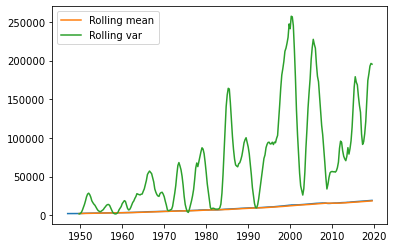

      Autocorrelation plot      
--------------------------------



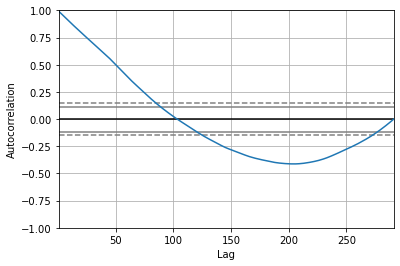

In [4]:
check_time_series_stationary(usgdp.GDPC1)

Szereg jest niestacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -2.1605
p-value             :     0.2209
--------------------------------



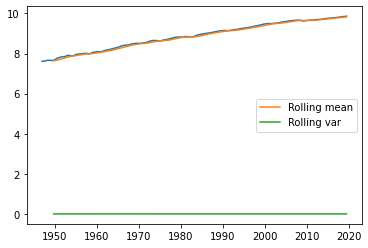

      Autocorrelation plot      
--------------------------------



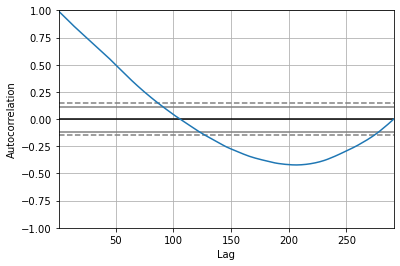

In [5]:
log_usgdp = np.log(usgdp)
check_time_series_stationary(log_usgdp.GDPC1)

Szereg jest stacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -8.4548
p-value             :     0.0000
--------------------------------



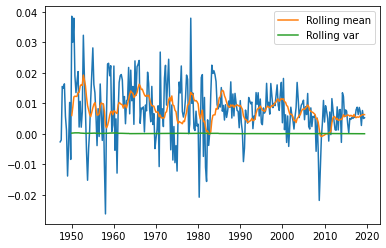

      Autocorrelation plot      
--------------------------------



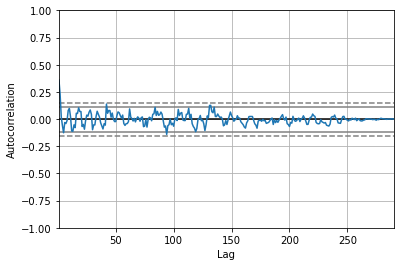

In [6]:
log_usgdp_diff = log_usgdp.diff(1).dropna()
check_time_series_stationary(log_usgdp_diff.GDPC1) 

/home/mdabrowski-phd/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


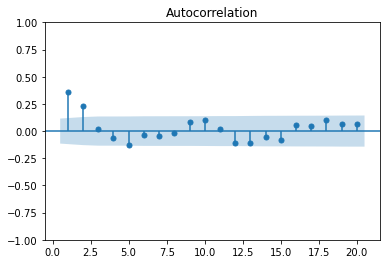

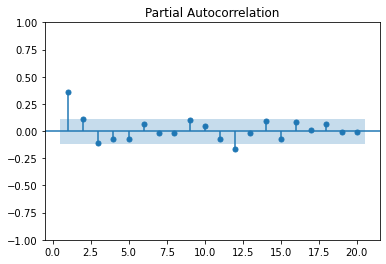

In [7]:
plot_acf(log_usgdp_diff, lags = 20, zero = False)
plot_pacf(log_usgdp_diff, lags = 20, zero = False)
plt.show()

In [20]:
m1 = ARIMA(endog=log_usgdp, order=(3, 1, 2), trend='t').fit()
m1.summary()

/home/mdabrowski-phd/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  GDPC1   No. Observations:                  291
Model:                 ARIMA(3, 1, 2)   Log Likelihood                 969.097
Date:                Sun, 04 Jun 2023   AIC                          -1924.194
Time:                        15:27:00   BIC                          -1898.505
Sample:                    01-01-1947   HQIC                         -1913.902
                         - 07-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0077      0.001     12.214      0.000       0.006       0.009
ar.L1          1.1147      0.302      3.687      0.000       0.522       1.707
ar.L2         -0.1375      0.372     -0.370      0.712      -0.866       0.591
ar.L3         -0.1854      0.107     -1.734      0.083      -0.395       0.024
ma.L1         -0.7990      0.306     -2.608      0.009      -1.400      -0.198
ma.L2          0.0458      0.279      0.164      0.869      -0.501       0.592
sigma2      7.316e-05    4.3e-06     16.995      0.000    6.47e-05    8.16e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                56.58
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Dopasowanie modelu

Diagnostyka modelu sprowadza się m.in do:
- analizy reszt - jeśli dopasowany model poprawnie wyjaśnia dynamikę czasową analizowanego zjawiska, w szeregu reszt nie powinno być widać żadnych regularnych zachowań (trendu, sezonowości), ani istotnej korelacji czasowej (dla żadnego z opóźnień), stąd:

    - w praktyce możemy posługiwać się regułą, że reszty dopasowanego modelu powinny zachowywać się w przybliżeniu jak biały szum,
    - często weryfikujemy również dodatkowo, czy rozkład reszt można uznawać za rozkład normalny
    
W praktyce sprawdzamy najczęściej 
- wykres reszt - na wykresie nie powinno być widocznych regularnych wzorów ani niejednorodności wariancji, 
- test Durbina-Watsona - niezależność błędów obserwacji, dobrze dopasowany model zakłada, że otrzymywane reszty są niezależne od siebie, innymi słowy, rozkład ich jest losowy, przypadkowy, bez stale występującego wzorca. 
- ACF/PACF dla reszt - na wykresach nie powinno być widocznych istotnych korelacji (tzw. *graficzny test białoszumowości*),
- weryfikacja normalności rozkładu reszt - wykorzystujemy narzędzia graficzne (np. Q-Q plot lub histogram) oraz formalne testy statystyczne normalności (np. test Shapiro-Wilka).

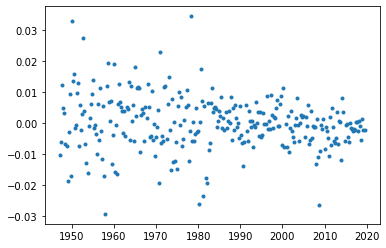

DATE
1947-01-01    0.007723
1947-04-01    7.625021
1947-07-01    7.618500
1947-10-01    7.615815
1948-01-01    7.637975
                ...   
2018-07-01    9.838983
2018-10-01    9.846108
2019-01-01    9.847021
2019-04-01    9.855440
2019-07-01    9.860694
Length: 291, dtype: float64

In [32]:
plt.plot(m1.resid[1:], '.')  # pomijamy pierwsze residuum w związku z różnicowaniem szeregu
plt.show()

m1.fittedvalues

### Test Durbina-Watsona

Statystyka DW mieści się w przedziale od 0 do 4:
- w przypadku DW > 2, zakłada się występowanie autokorelacji ujemnej, 
- w przypadku DW < 2 autokorelacji dodatniej,
- wartości zbliżone do 2 oznaczają brak występowania autokorelacji. 

In [36]:
sm.stats.durbin_watson(m1.resid[1:])  # mieści się w zakresie 1.8 < DW < 2.2

1.9712376299886878

### Wykres reszt za pomocą ACF i PACF

17.05872210923198


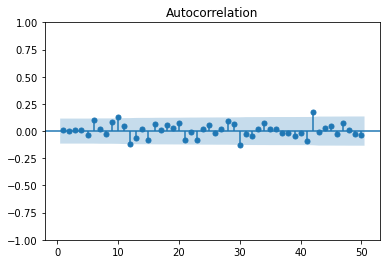

/home/mdabrowski-phd/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


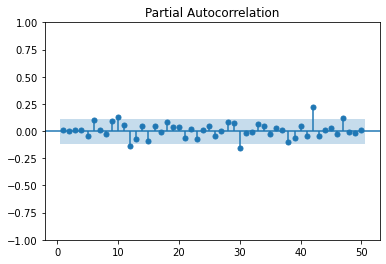

In [35]:
# wartości powinny znajdować się w "pasie"
print(np.sqrt(len(m1.resid)))

plot_acf(m1.resid[1:], lags=50, zero=False)
plot_pacf(m1.resid[1:], lags=50, zero=False)
plt.show()

### Weryfikacja normalności rozkładu reszt

1. Test Shapiro-Wilka

    H0: Rozkład badanej cechy jest rozkładem normalnym.

    H1: Rozkład badanej cechy nie jest rozkładem normalnym.
    

2. Wykres $Q-Q$

In [39]:
print(stats.shapiro(m1.resid[1:]))
print(stats.normaltest(m1.resid[1:]))

# sm.stats.jarque_bera(m1.resid[1:])[:2]

ShapiroResult(statistic=0.9699432253837585, pvalue=9.29562793317018e-06)
NormaltestResult(statistic=19.268619226165182, pvalue=6.544440115729878e-05)


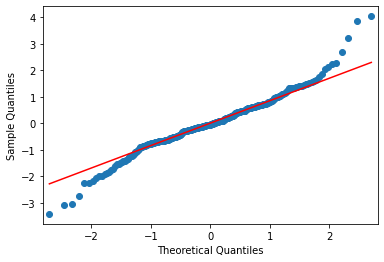

In [131]:
from statsmodels.graphics.api import qqplot

qqplot(m1.resid[1:], line='q', fit=True)
plt.show()  # ogony nie są normalne

### Analiza istotności współczynników w modelu

Jakość dopasowania modelu można niekiedy poprawić eliminując te współczynniki, które są statystycznie nieistotne, to znaczy nie odgrywają istotnej roli w wyjaśnianiu dynamiki czasowej modelowanego zjawiska.

Formalnie, sprawdzamy hipotezę zerową postaci 
$$H_0: \phi_i = 0,$$
kontra hipotezie alternatywnej 
$$H_1: \phi_i \neq 0$$.

Odrzucenie $H_0$ przemawia za pozostawieniem współczynnika $\phi_i$ w modelu.

In [46]:
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  GDPC1   No. Observations:                  291
Model:                 ARIMA(3, 1, 2)   Log Likelihood                 969.097
Date:                Sun, 04 Jun 2023   AIC                          -1924.194
Time:                        15:52:49   BIC                          -1898.505
Sample:                    01-01-1947   HQIC                         -1913.902
                         - 07-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0077      0.001     12.214      0.000       0.006       0.009
ar.L1          1.1147      0.302      3.687      0.000       0.522       1.707
ar.L2         -0.1375      0.372     -0.370      0.712      -0.866       0.591
ar.L3         -0.1854      0.107     -1.734      0.083      -0.395       0.024
ma.L1         -0.7990      0.306     -2.608      0.009      -1.400      -0.198
ma.L2          0.0458      0.279      0.164      0.869      -0.501       0.592
sigma2      7.316e-05    4.3e-06     16.995      0.000    6.47e-05    8.16e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                56.58
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Dopasowanie (Predykcja) na podstawie modelu

In [50]:
usgdp

,GDPC1
DATE,
1947-01-01,2033.061
1947-04-01,2027.639
1947-07-01,2023.452
1947-10-01,2055.103
1948-01-01,2086.017
...,...
2018-07-01,18732.720
2018-10-01,18783.548
2019-01-01,18927.281


- tutaj tworzymy predykcję dla obserwacji na podstawie struktury opisanej w modelu i konkretnych danych, które mają wcześniejsze indeksy czasowe

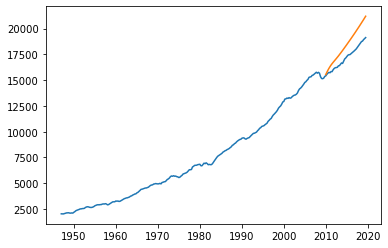

In [54]:
# 'dynamic=False' oznacza prognozowanie na podstawie wszystkich danych z przeszłości (rzeczywistych, a nie wyliczonych
# przez model od wartości parametru 'start'. W przeciwnym wypadku bazujemy tylko na wyoczonym modelu)

predict_logusgdp_dynamic = m1.predict(start='2010-01-01', dynamic=True)

plt.plot(usgdp.index,usgdp.GDPC1)
plt.plot(usgdp.index[usgdp.index>='2010-01-01'], np.exp(predict_logusgdp_dynamic))
plt.show()

- w kolejnym kroku nie bierzemy predykcji, którą uzyskaliśmy, tylko prawdziwą wartość szeregu dla wcześniejszego czasu (dane historyczne)

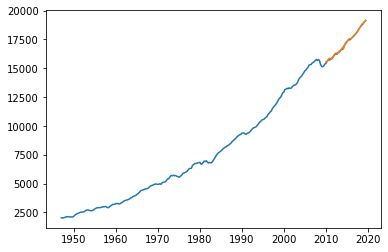

In [55]:
# chcemy prognozować wartości szeregu od określonego momentu w przyszłość

predict_logusgdp_nondynamic = m1.predict(start='2010-01-01', dynamic=False) 

plt.plot(usgdp.index,usgdp.GDPC1)
plt.plot(usgdp.index[usgdp.index>='2010-01-01'],np.exp(predict_logusgdp_nondynamic))
plt.show()

## Zadanie 2
Dla danych

1. `southern`

2. `daily-total-female-births`

dopasuj odpowiedni model $\text{AR}(p)$ lub $\text{MA}(q)$ lub $\text{ARMA}(p, q)$ (rząd $p$ i $q$ wyznacz na podstawie wykresów ACF i PACF). Sprawdź dopasowanie modeli.

### `southern`

In [88]:
southern = pd.read_csv('../data/southern.csv', parse_dates=['Date'], index_col='Date')
southern.head()

,Southern
Date,
1955-01-01,-0.7
1955-02-01,1.3
1955-03-01,0.1
1955-04-01,-0.9
1955-05-01,0.8


Szereg jest stacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -6.1813
p-value             :     0.0000
--------------------------------



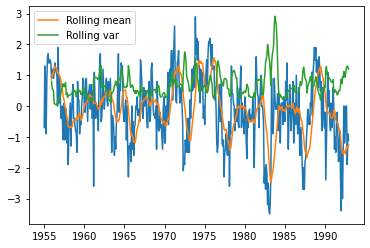

      Autocorrelation plot      
--------------------------------



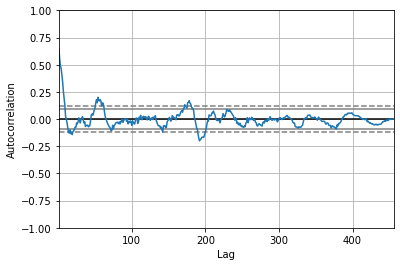

In [137]:
check_time_series_stationary(southern.Southern)

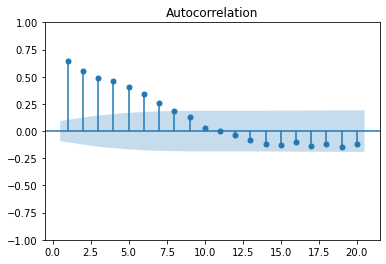

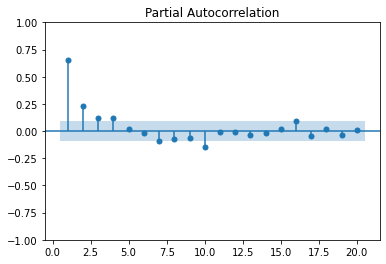

In [138]:
plot_acf(southern.Southern, lags = 20, zero = False)
plot_pacf(southern.Southern, lags = 20, zero = False)
plt.show()

Szereg jest stacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -8.1383
p-value             :     0.0000
--------------------------------



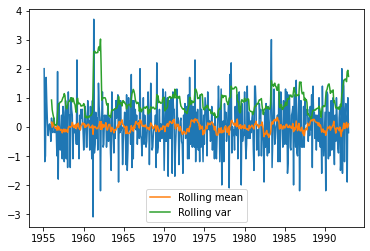

      Autocorrelation plot      
--------------------------------



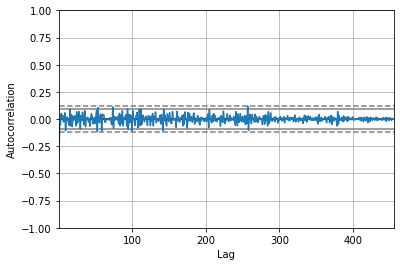

In [182]:
southern_dec = southern.Southern.diff(1).dropna()
check_time_series_stationary(southern_dec)

Szereg jest stacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -7.9992
p-value             :     0.0000
--------------------------------



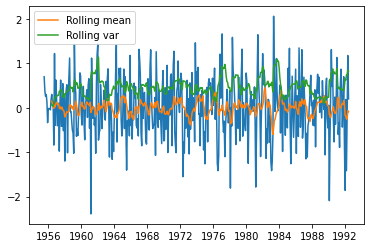

      Autocorrelation plot      
--------------------------------



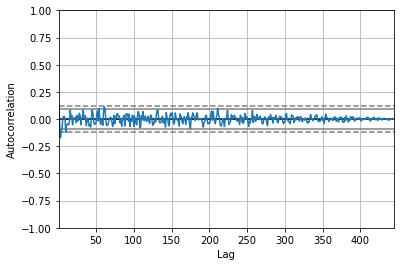

In [234]:
# usuwanie trendu oraz sezonowości

southern_dec = seasonal_decompose(southern, model = 'additive')
check_time_series_stationary(southern_dec.resid.dropna())

In [ ]:
southern_res = southern_dec.resid.dropna()

# inny sposób (ręczne usunięcie trendu <-- wystarcza!)

# southern_res = southern.Southern.diff(1).dropna()
# check_time_series_stationary(southern_res)

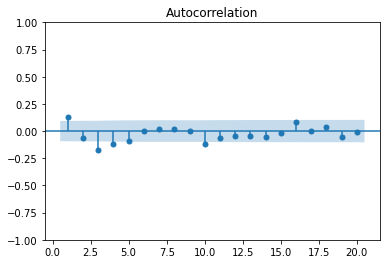

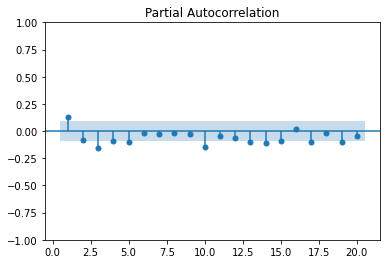

In [235]:
plot_acf(southern_res, lags = 20, zero = False)
plot_pacf(southern_res, lags = 20, zero = False)
plt.show()

In [309]:
m2 = ARIMA(endog=southern_res, order=(1, 0, 0), trend='n').fit()
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                  444
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -449.829
Date:                Sun, 04 Jun 2023   AIC                            903.658
Time:                        21:37:33   BIC                            911.849
Sample:                    07-01-1955   HQIC                           906.888
                         - 06-01-1992                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1270      0.047      2.691      0.007       0.035       0.219
sigma2         0.4441      0.028     15.894      0.000       0.389       0.499
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 2.63
Prob(Q):                              0.82   Prob(JB):                         0.27
Heteroskedasticity (H):               1.19   Skew:                            -0.11
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

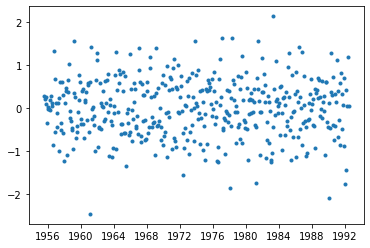

In [310]:
plt.plot(m2.resid[1:], '.')  # pomijamy pierwsze residuum w związku z różnicowaniem szeregu
plt.show()

In [311]:
sm.stats.durbin_watson(m2.resid[1:])  # mieści się w zakresie 1.8 < DW < 2.2

1.9804476806674924

21.071307505705477


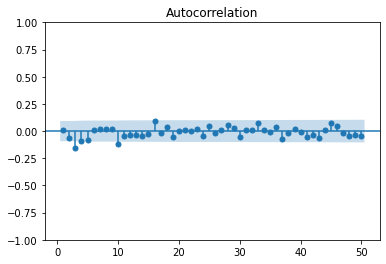

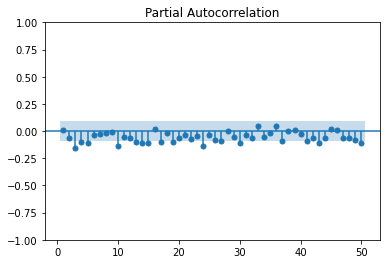

In [312]:
# wartości powinny znajdować się w "pasie"
print(np.sqrt(len(m2.resid)))

plot_acf(m2.resid[1:], lags=50, zero=False)
plot_pacf(m2.resid[1:], lags=50, zero=False)
plt.show()

In [313]:
# reszty nie są normalne (istnieje wewnętrzna struktura)

print(stats.shapiro(m2.resid[1:]))
print(stats.normaltest(m2.resid[1:]))

sm.stats.jarque_bera(m2.resid[1:])[:2]

ShapiroResult(statistic=0.9963493943214417, pvalue=0.4087394177913666)
NormaltestResult(statistic=2.7106952197551584, pvalue=0.25785764500679836)


(2.6036342167123143, 0.2720370228971864)

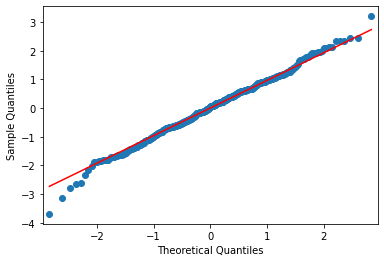

In [314]:
qqplot(m2.resid[1:], line='q', fit=True)
plt.show()

### `daily-total-female-births`

In [93]:
daily_births = pd.read_csv('../data/daily-total-female-births.csv', parse_dates=['Date'], index_col='Date')
daily_births.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


Szereg jest stacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -4.8083
p-value             :     0.0001
--------------------------------



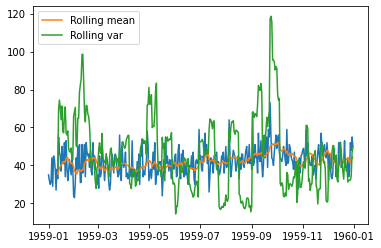

      Autocorrelation plot      
--------------------------------



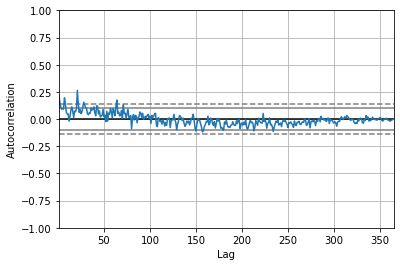

In [94]:
check_time_series_stationary(daily_births.Births)

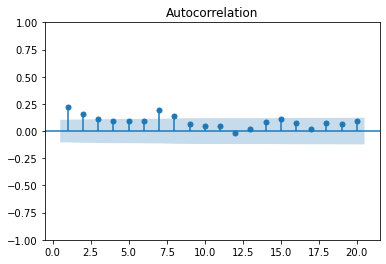

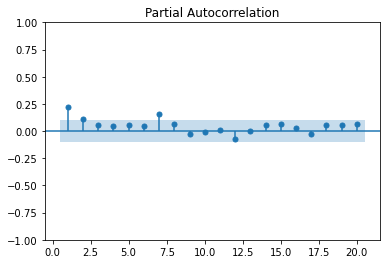

In [95]:
plot_acf(daily_births.Births, lags = 20, zero = False)
plot_pacf(daily_births.Births, lags = 20, zero = False)
plt.show()

In [119]:
m3 = ARIMA(endog=daily_births.Births, order=(2, 0, 1)).fit()
m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Births   No. Observations:                  365
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1228.142
Date:                Sun, 04 Jun 2023   AIC                           2466.283
Time:                        19:16:32   BIC                           2485.783
Sample:                    01-01-1959   HQIC                          2474.033
                         - 12-31-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.7926      1.712     24.417      0.000      38.438      45.147
ar.L1          1.1111      0.067     16.576      0.000       0.980       1.243
ar.L2         -0.1206      0.062     -1.941      0.052      -0.242       0.001
ma.L1         -0.9535      0.030    -31.958      0.000      -1.012      -0.895
sigma2        48.9212      3.401     14.384      0.000      42.255      55.587
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                24.66
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                             0.55
Prob(H) (two-sided):                  0.79   Kurtosis:                         3.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

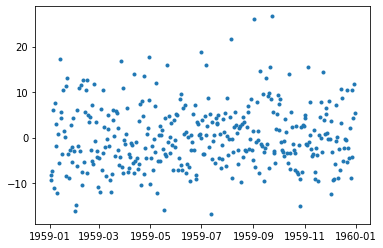

In [120]:
plt.plot(m3.resid[1:], '.')  # pomijamy pierwsze residuum w związku z różnicowaniem szeregu
plt.show()

In [135]:
sm.stats.durbin_watson(m3.resid[1:])  # mieści się w zakresie 1.8 < DW < 2.2

2.0104541904881144

19.1049731745428


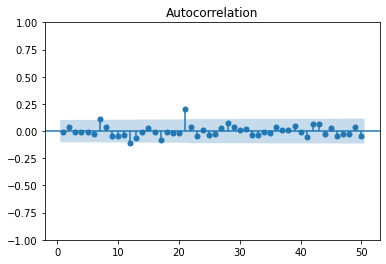

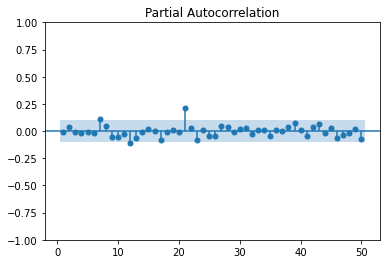

In [134]:
# wartości powinny znajdować się w "pasie"
print(np.sqrt(len(m3.resid)))

plot_acf(m3.resid[1:], lags=50, zero=False)
plot_pacf(m3.resid[1:], lags=50, zero=False)
plt.show()

In [127]:
print(stats.shapiro(m3.resid[1:]))
print(stats.normaltest(m3.resid[1:]))

sm.stats.jarque_bera(m3.resid[1:])[:2]

ShapiroResult(statistic=0.9820675849914551, pvalue=0.00016991738812066615)
NormaltestResult(statistic=21.317804060706504, pvalue=2.349079230616705e-05)


(24.15294782114549, 5.691857514880466e-06)

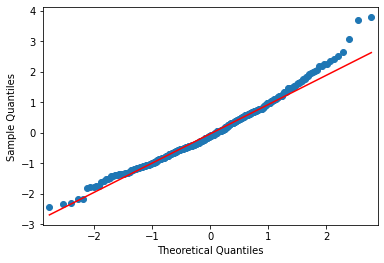

In [133]:
qqplot(m3.resid[1:], line='q', fit=True)
plt.show()  # ogony nie są normalne

# Kryteria informacyjne oceniają jakość dopasowania modelu

Kryteria informacyjne oceniają jakość dopasowania modelu na podstawie danych historycznych, kontrolując jednocześnie stopień złożoności modelu. 

Zwiększając liczbę parametrów modelu (zwiększając złożoność modelu), możemy zazwyczaj otrzymać lepsze dopasowanie modelu do danych. Zbyt dobre dopasowanie modelu może jednak powodować problemy, a w szczególności może prowadzić do złych prognoz. Z tego powodu w postaci kryteriów wyboru modelu występuje składnik kary za wymiar modelu, w ogólności:

$$C(\text{model}) = -2 \ln(L) + \text{kara(liczba współczynników modelu)},$$
gdzie $L$ oznacza funkcję wiarogodności.

**AIC (Akaike Information Criterium)**
$$AIC(p, q) = -2 \ln(L) + 2\cdot(p+q+1)$$

**BIC (Bayesian Information Criterium)**
$$BIC(p, q) = -2 \ln(L) + (p+q+1)\cdot\ln n$$

### Kryteria oceniające dokładność prognoz (bazujące na błędach predykcji)

- MSE - Mean Squared Error
- MAE - Median Absolute Error

Należy jednak pamiętać, że w odróżnieniu od kryteriów informacyjnych, kryteria oparte na błędach predykcji nie mają wbudowanego mechanizmu, który "karałby" za złożoność modelu.

## Zadanie 3

Napisz funkcję, która dla dowolnego szeregu czasowego i modelu `ARMA` sprawdzi jego dopasowanie oraz jakość predykcji na podstawie MSE i MAE.
Zawrzyj informację o wartości oszacowanych współczynników modelu, wartości AIC i BIC, wartości statystyki Durbina-Watsona oraz ocenę normalności reszt.

Następnie sprawdź dopasowanie dla kilku wybranych modeli ARMA.

In [56]:
def mse(y, yhat):
    return np.mean((y - yhat)**2)

def mae(y, yhat):
    return np.median(np.abs(y - yhat))

In [69]:
def fit_ARMA(ts, p, q, pred_start, pred_end):
    
    arma = ARIMA(ts, order=(p, 0, q)).fit()
    
    print('AR params %s' % arma.arparams)
    print('MA params %s' % arma.maparams)
    
    print('AIC: %.2f, \nBIC: %.2f' % (arma.aic, arma.bic))
    
    dw_test = sm.stats.durbin_watson(arma.resid[1:])
    print("Statystyka Durbina-Watsona {}".format(dw_test))
    
    normal_test = stats.shapiro(arma.resid)
    print("P-value testu Shapiro-Wilka: {}".format(normal_test[1]))
    
    pred = arma.predict(start=pred_start, end=pred_end, dynamic=True)
        
    mse_val = mse(ts.values[1:], pred.values[1:])
    mae_val = mae(ts.values[1:], pred.values[1:])
    print('MSE: {}'.format(mse_val))
    print('MAE: {}'.format(mae_val))
    
    plt.plot(ts)
    plt.plot(pred, 'g--')
    plt.show()

AR params [ 1.11466482 -0.13750441 -0.18540795]
MA params [-0.79901596  0.04582286]
AIC: -1924.19, 
BIC: -1898.48
Statystyka Durbina-Watsona 1.9712376304800334
P-value testu Shapiro-Wilka: 1.0
MSE: 8.626352193758965e-05
MAE: 0.004687675468642103


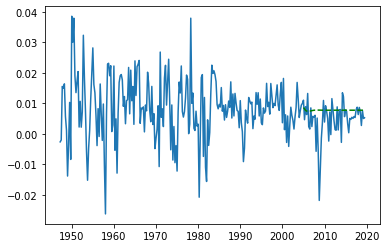

In [70]:
fit_ARMA(log_usgdp.diff(1), p=3, q=2, pred_start='2005-01-01', pred_end='2019-07-01')

# Optymalna wartości $p$ i $q$ na podstawie kryterium oceniającego dobroć dopasowania modelu (AIC lub BIC)

## Zadanie 4
Napisz funkcję, która dla danego szeregu czasowego wyznaczy najlepszy rząd $p$ modelu $\text{AR}(p)$ na podstawie kryterium AIC i BIC.

In [82]:
import warnings
warnings.filterwarnings('ignore')

def find_the_best_parametr_ar(ts, max_p=10):
    
    aic = np.zeros(max_p)
    bic = np.zeros(max_p)
    
    for i in range(1, max_p + 1):
        
        ar = ARIMA(endog=ts, order=(i, 0, 0)).fit()
        aic[i-1] = ar.aic
        bic[i-1] = ar.bic
        
    plt.plot(range(1, max_p + 1), aic, 'r.-', label="AIC")
    plt.plot(range(1, max_p + 1), bic, 'g.-', label="BIC")
    plt.legend()
    plt.show()
        
    print("Najlepszy rząd p: {} dla kryterium AIC (AIC={})".format(np.argmin(aic) + 1, np.min(aic)))
    print("Najlepszy rząd p: {} dla kryterium BIC (BIC={})".format(np.argmin(bic) + 1, np.min(bic)))

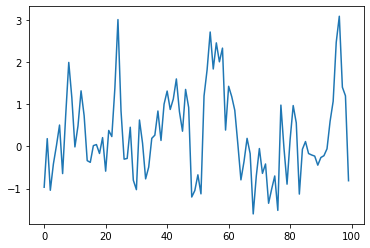

In [83]:
np.random.seed(128)
N = 201
e = np.random.normal(0, 1, N)
ar1 = np.zeros(N)

for i in range(1, N):
    ar1[i] = 0.8 * ar1[i-1] + e[i]

ar1 = ar1[101:]

plt.plot(ar1)
plt.show()

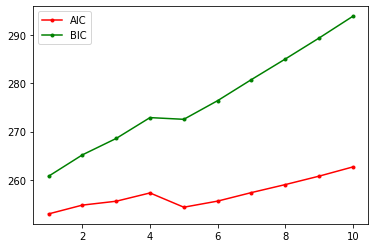

Najlepszy rząd p: 1 dla kryterium AIC (AIC=252.92619536942578)
Najlepszy rząd p: 1 dla kryterium BIC (BIC=260.74170592739006)


In [84]:
find_the_best_parametr_ar(ar1, max_p=10)

## Zadanie 5

Napisz funkcję, która dla danego szeregu czasowego wyznaczy najlepsze rzędy $p$ i $q$ modelu $\text{ARMA}(p, q)$ na podstawie kryterium AIC i BIC.

In [85]:
def find_the_best_arma(ts, max_p=10, max_q=10):
    
    aic = np.zeros((max_p, max_q))
    bic = np.zeros((max_p, max_q))
    
    for i in range(max_p):
        for j in range(max_q):
            
            arma = ARIMA(endog=ts, order=(i + 1, 0, j + 1)).fit()
            aic[i, j] = arma.aic
            bic[i, j] = arma.bic
            print('ARMA(%d, %d): AIC=%f, BIC=%f' % (i+1, j+1, arma.aic, arma.bic))
            
    print("-" * 30)
    min_aic = np.min(aic)
    min_arg_aic = np.argwhere(aic == min_aic)[0]
    print("MINIMUM AIC=%f dla p=%d, q=%d" % (min_aic, min_arg_aic[0] + 1, min_arg_aic[1] + 1))
    
    min_bic = np.min(bic)
    min_arg_bic = np.argwhere(bic == min_bic)[0]
    print("MINIMUM BIC=%f dla p=%d, q=%d" % (min_bic, min_arg_bic[0] + 1, min_arg_bic[1] + 1))

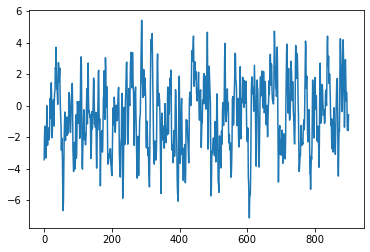

In [86]:
np.random.seed(129)
N5 = 1001
e = np.random.normal(0, 1, N5)
arma = 10 * np.ones(N5)

for i in range(1, N5):
    arma[i] = 0.7 * arma[i-1] + 0.8 * e[i-1] + e[i]

arma = arma[101:]

plt.plot(arma)
plt.show()

In [87]:
find_the_best_arma(arma, max_p=5, max_q=5)

ARMA(1, 1): AIC=2530.561091, BIC=2549.770670
ARMA(1, 2): AIC=2532.533262, BIC=2556.545235
ARMA(1, 3): AIC=2534.302852, BIC=2563.117220
ARMA(1, 4): AIC=2533.992539, BIC=2567.609303
ARMA(1, 5): AIC=2535.965001, BIC=2574.384159
ARMA(2, 1): AIC=2532.531565, BIC=2556.543539
ARMA(2, 2): AIC=2533.591513, BIC=2562.405881
ARMA(2, 3): AIC=2535.447574, BIC=2569.064338
ARMA(2, 4): AIC=2530.027491, BIC=2568.446649
ARMA(2, 5): AIC=2534.725241, BIC=2577.946794
ARMA(3, 1): AIC=2534.285812, BIC=2563.100180
ARMA(3, 2): AIC=2535.443156, BIC=2569.059919
ARMA(3, 3): AIC=2529.178707, BIC=2567.597865
ARMA(3, 4): AIC=2531.572968, BIC=2574.794521
ARMA(3, 5): AIC=2531.621815, BIC=2579.645763
ARMA(4, 1): AIC=2533.019008, BIC=2566.635772
ARMA(4, 2): AIC=2535.066328, BIC=2573.485486
ARMA(4, 3): AIC=2530.222197, BIC=2573.443749
ARMA(4, 4): AIC=2524.093722, BIC=2572.117670
ARMA(4, 5): AIC=2527.619964, BIC=2580.446307
ARMA(5, 1): AIC=2534.848123, BIC=2573.267282
ARMA(5, 2): AIC=2531.131245, BIC=2574.352798
ARMA(5, 3)

In [71]:
find_the_best_arma(log_usgdp.diff(1), max_p=5, max_q=5)

ARMA(1, 1): AIC=-1925.127489, BIC=-1910.434196
ARMA(1, 2): AIC=-1928.021677, BIC=-1909.655061
ARMA(1, 3): AIC=-1925.852781, BIC=-1903.812842
ARMA(1, 4): AIC=-1924.802306, BIC=-1899.089043
ARMA(1, 5): AIC=-1926.820313, BIC=-1897.433726
ARMA(2, 1): AIC=-1924.064349, BIC=-1905.697732
ARMA(2, 2): AIC=-1928.031774, BIC=-1905.991834
ARMA(2, 3): AIC=-1925.927449, BIC=-1900.214186
ARMA(2, 4): AIC=-1923.392907, BIC=-1894.006321
ARMA(2, 5): AIC=-1923.751891, BIC=-1890.691982
ARMA(3, 1): AIC=-1925.866200, BIC=-1903.826261
ARMA(3, 2): AIC=-1924.194279, BIC=-1898.481016
ARMA(3, 3): AIC=-1926.152686, BIC=-1896.766100
ARMA(3, 4): AIC=-1923.175145, BIC=-1890.115235
ARMA(3, 5): AIC=-1919.670104, BIC=-1882.936872
ARMA(4, 1): AIC=-1925.598859, BIC=-1899.885596
ARMA(4, 2): AIC=-1923.035771, BIC=-1893.649185
ARMA(4, 3): AIC=-1925.190377, BIC=-1892.130468
ARMA(4, 4): AIC=-1921.581069, BIC=-1884.847836
ARMA(4, 5): AIC=-1916.604486, BIC=-1876.197930
ARMA(5, 1): AIC=-1926.191361, BIC=-1896.804775
ARMA(5, 2): A